In [1]:
import spotiphy
import numpy as np
import pandas as pd
import matplotlib as mpl
import scanpy as sc
import squidpy as sq
import importlib as imp

In [3]:
%%time
results_folder = 'Results/Simulation_221_1/'
adata_sc = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/NewMerge_noHarmony.h5ad")
adata_st = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/Simulated ST/ST_Simulated_221_1.h5ad")
adata_st.var_names_make_unique()
key_type = 'majortype'
type_list = sorted(list(adata_sc.obs[key_type].unique()))
print(f'There are {len(type_list)} cell types: {type_list}')

CPU times: total: 266 ms
Wall time: 258 ms


### Deconvolution

In [3]:
adata_sc, adata_st = spotiphy.initialization(adata_sc, adata_st, verbose=1)
adata_sc_orig = adata_sc.copy()
adata_st_orig = adata_st.copy()

Convert expression matrix to array: 0.2s
Normalization: 34.51s
Filtering: 51.15s
Find common genes: 2.29s


In [68]:
# adata_sc = adata_sc_orig.copy()
# adata_st = adata_st_orig.copy()
# imp.reload(spotiphy.sc_reference)
# results_folder = 'Results/Simulation1/Method 9/'

In [4]:
marker_gene_dict = spotiphy.sc_reference.marker_selection_1(adata_sc, key_type=key_type, return_dict=True, n_select=50,
                                                            threshold_p=0.1, threshold_fold=1.5, q=0.15)
marker_gene = []
marker_gene_label = []
for type_ in type_list:
    marker_gene.extend(marker_gene_dict[type_])
    marker_gene_label.extend([type_]*len(marker_gene_dict[type_]))
marker_gene_df = pd.DataFrame({'gene':marker_gene, 'label':marker_gene_label})
marker_gene_df.to_csv(results_folder+'marker_gene.csv')
adata_sc = adata_sc[:, marker_gene]
adata_st = adata_st[:, marker_gene]

27it [00:00, 34.43it/s]


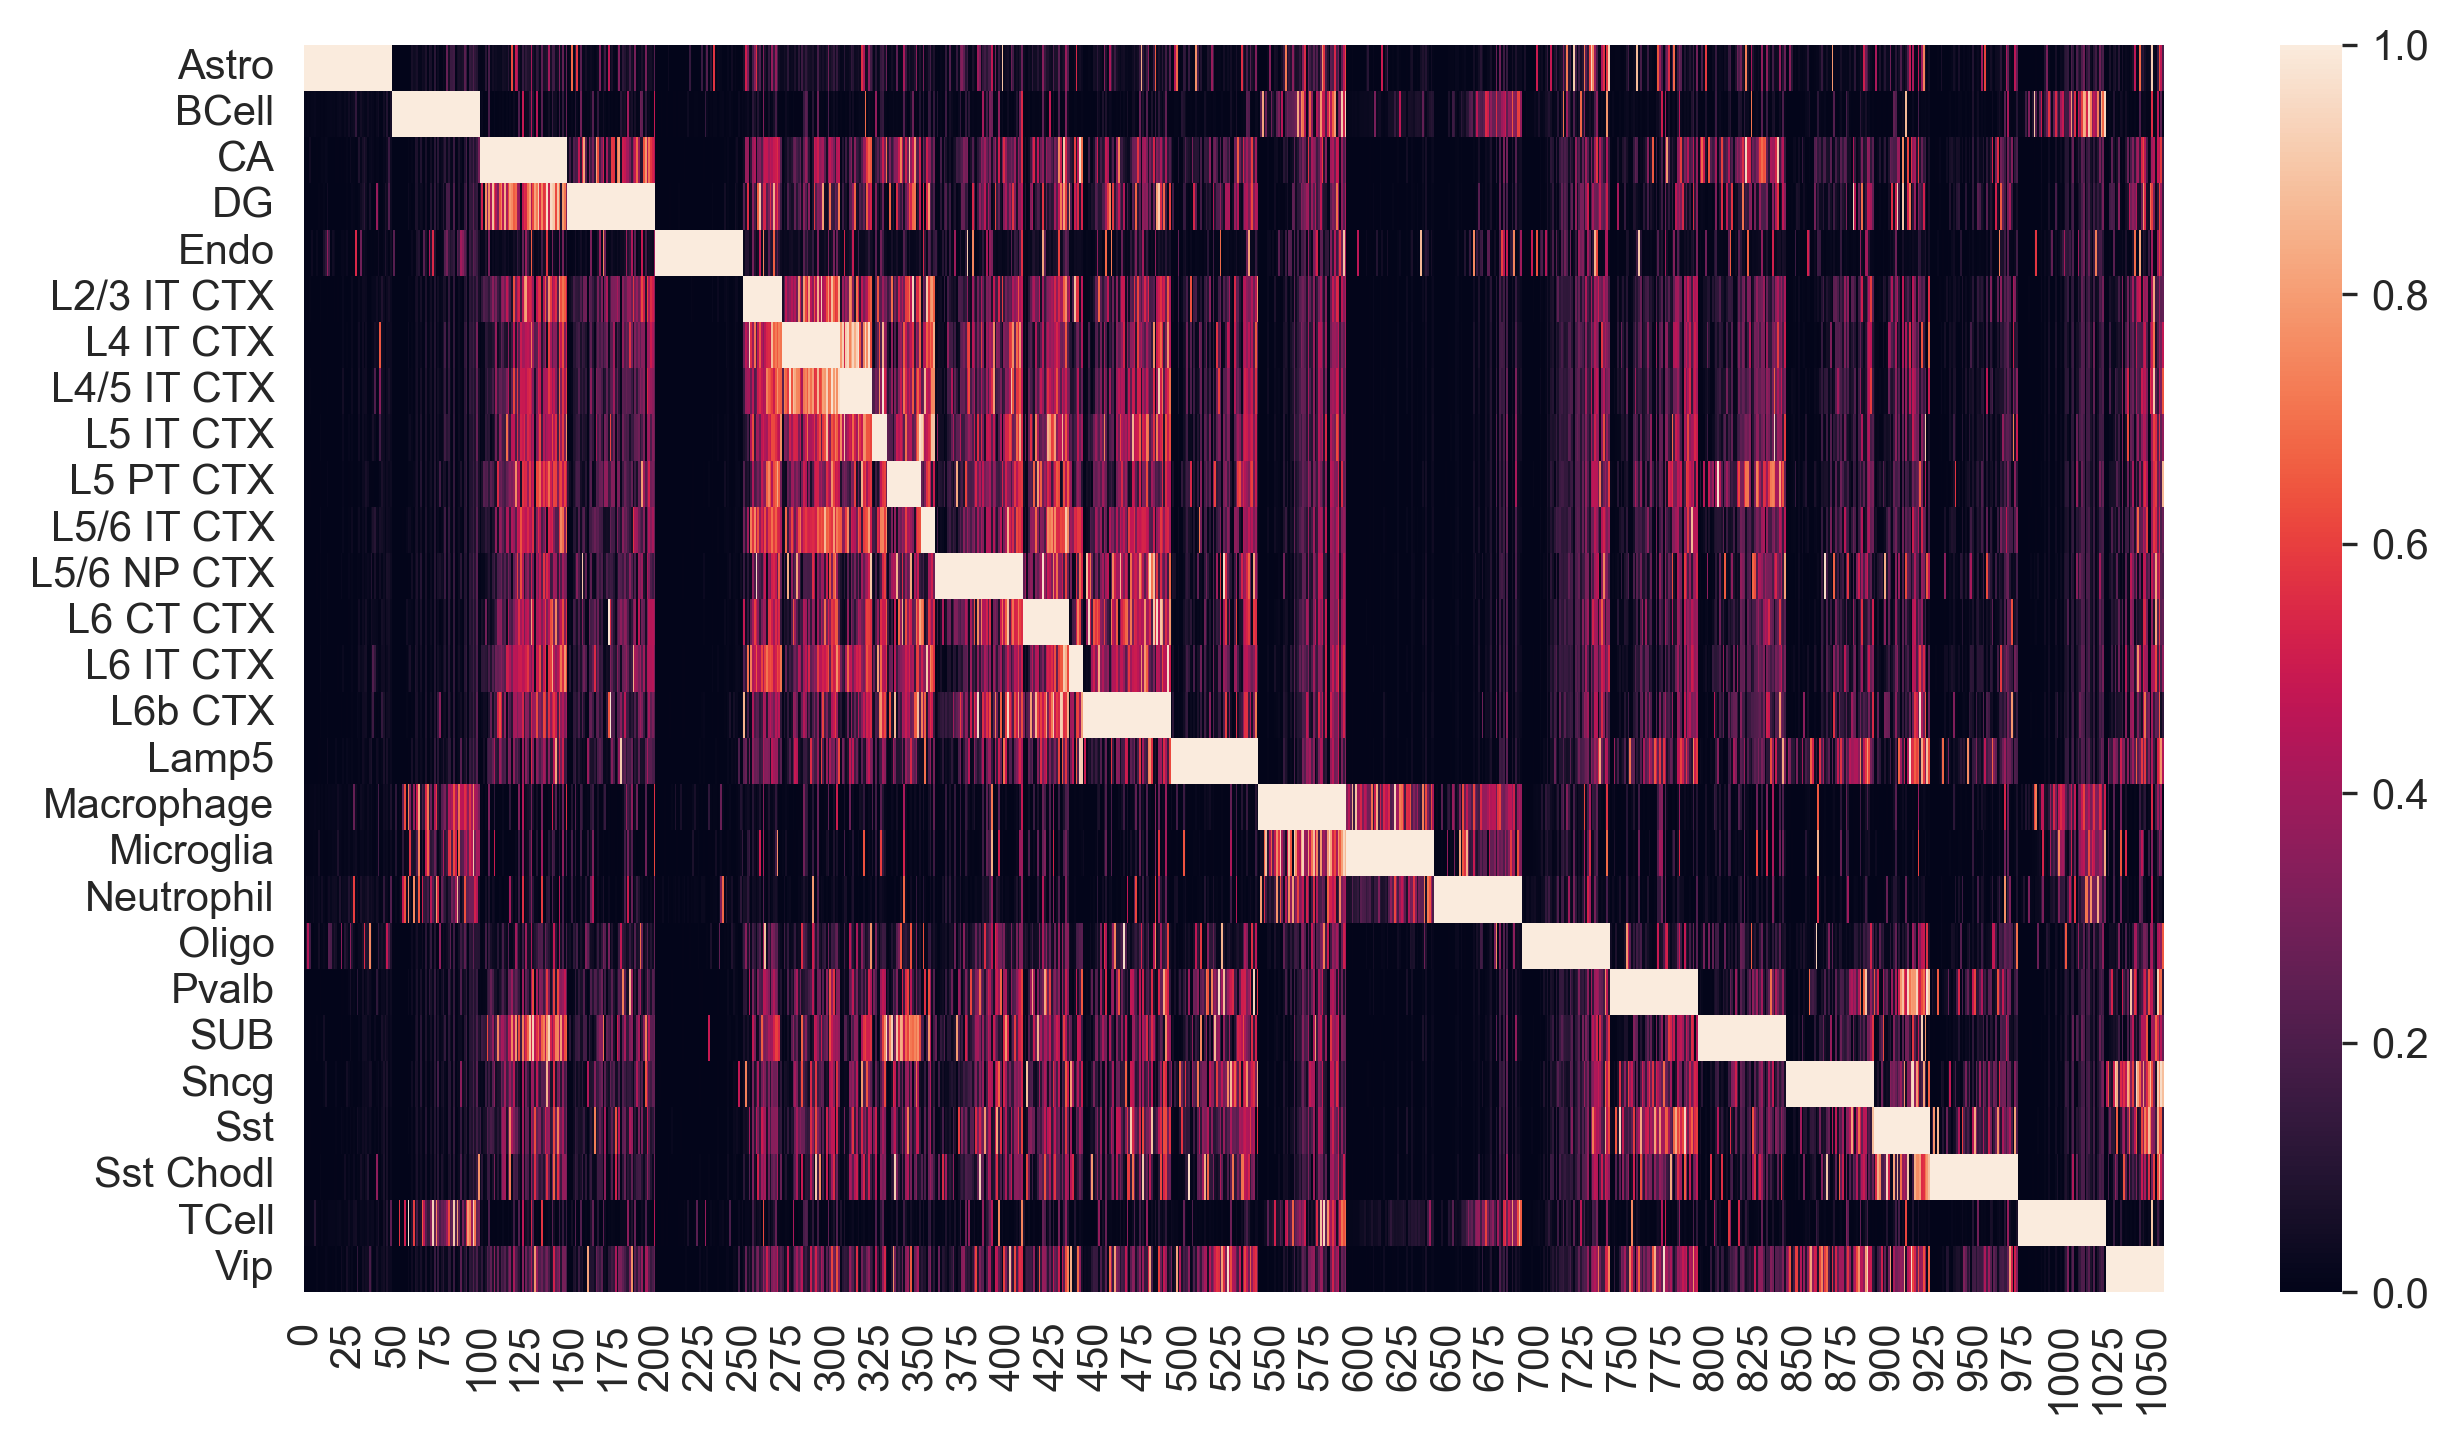

In [5]:
sc_ref = spotiphy.construct_sc_ref(adata_sc, key_type=key_type)
spotiphy.sc_reference.plot_heatmap(adata_sc, key_type, save=True, out_dir=results_folder)

In [6]:
X = np.array(adata_st.X)
pyro_params = spotiphy.deconvolution.deconvolute(X, sc_ref, n_epoch=8000, plot=True, batch_prior=1)
sigma = pyro_params['sigma'].cpu().detach().numpy()
mean_exp = np.array([np.mean(np.sum(adata_sc.X[adata_sc.obs[key_type]==type_list[i]], axis=1))
                     for i in range(len(type_list))])
cell_proportion = sigma/mean_exp
cell_proportion = cell_proportion/np.sum(cell_proportion, axis=1)[:, np.newaxis]
adata_st.obs[type_list] = cell_proportion
np.save(results_folder+'proportion.npy', cell_proportion)

 95%|█████████▌| 7614/8000 [04:38<00:14, 27.31it/s]

In [ ]:
cell_proportion = np.load(results_folder+'proportion.npy')
adata_st.obs[type_list] = cell_proportion
# type_list_order = ['L2/3 IT CTX', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX', 'L5/6 NP CTX', 'L6 CT CTX', 'L6b CTX',
#                    'CAs', 'DG', 'Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip', 'Endo', 'Astro', 'Oligo', 'Pericyte',
#                    'Macrophage', 'Microglia', 'Neutrophil', 'TCell', 'BCell']
type_list_order = type_list

In [8]:
vmax = np.quantile(adata_st.obs[type_list_order].values, 0.97, axis=0)
vmax[vmax<0.05] = 0.05
adata_st.var.rename(index={'Lamp5': 'Lamp5_g', 'Pvalb': 'Pvalb_g', 'Sst': 'Sst_g', 'Vip': 'Vip_g', 'Sncg': 'Sncg_g'},
                    inplace=True)
with mpl.rc_context({'figure.figsize': [4, 4.5], 'figure.dpi': 400}):
    ax = sc.pl.spatial(adata_st, cmap='magma', color=type_list_order, img_key='hires', vmin=0, vmax=list(vmax), ncols=7,
                       size=1.3, show=False)
    ax[0].get_figure().savefig(results_folder+'spotiphy.jpg', bbox_inches='tight')

### Segmentation

In [9]:
%%time
img = sq.im.ImageContainer('F:/Ziqian Zheng/Spotiphy_data/ST/Sample216/Sample216.jpg')
Segmentation = spotiphy.segmentation.Segmentation(img['image'][:, :, 0], adata_st.obsm['spatial'],
                                                  out_dir=results_folder+'segmentation/')
Segmentation.segment_nucleus(save=True)
n_cell_df = Segmentation.n_cell_df

In [10]:
Segmentation.plot(crop=(3000, 3500, 3000, 3500), save=True, path=results_folder+'segmentation/segmentation_sample.jpg')

### Decomposition

In [10]:
results_folder = 'Results/Simulation_221_1/'
cell_proportion = np.load(results_folder+'proportion.npy')
n_cell_df = pd.read_csv(results_folder+'segmentation/n_cell_df.csv', header=0)
n_cell = n_cell_df['cell_count'].values
key_type = 'majortype'

In [13]:
adata_sc_orig = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/NewMerge_noHarmony.h5ad")
adata_st_orig = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/Simulated ST/ST_Simulated_221_1.h5ad")
adata_st_orig.var_names_make_unique()
adata_st_decomposed = spotiphy.deconvolution.decomposition(adata_st_orig, adata_sc_orig, key_type, cell_proportion,
                                                           save=True,out_dir=results_folder, verbose=1,
                                                           spot_location=adata_st.obsm['spatial'],
                                                           filtering_gene=True, n_cell=n_cell,
                                                           filename='ST_decomposition_simu_221.h5ad')

Prepared proportion data. Time use 0.17
Initialized scRNA and ST data. Time use 89.35


27it [00:09,  2.95it/s]


Processed scRNA and ST data. Time use 48.33
Decomposition complete. Time use 32.17
Constructed ST decomposition data file. Time use 3.60
Saved file to output folder. Time use 3.22


In [ ]:
adata_st_decomposed.obs